In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as c
from astropy.coordinates import Angle, SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time

In [3]:
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.datasets import Datasets, FluxPointsDataset, SpectrumDataset, SpectrumDatasetOnOff
from gammapy.data import DataStore
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.makers import ReflectedRegionsBackgroundMaker, RingBackgroundMaker, SafeMaskMaker, SpectrumDatasetMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (create_crab_spectral_model, ExpCutoffPowerLawSpectralModel, 
                                     LogParabolaSpectralModel, Models, PowerLawSpectralModel, SkyModel)

In [4]:
import logging
from pathlib import Path
from regions import CircleSkyRegion

In [5]:
def reduced_chi_sq(y, model_y, sigma, n_param):
    
    frac = (y - model_y) / sigma
    chi_sq = np.sum(frac ** 2)
    
    dof = len(y) - n_param
    
    return chi_sq, dof

In [6]:
path = 'BL_Lacertae/data/PointLike/'

In [7]:
log = logging.getLogger(__name__)

In [8]:
datastore = DataStore.from_dir(path)
datastore.info()

Data store:
HDU index table:
BASE_DIR: BL_Lacertae/data/PointLike
Rows: 52
OBS_ID: 83016 -- 83768
HDU_TYPE: ['aeff', 'edisp', 'events', 'gti']
HDU_CLASS: ['aeff_2d', 'edisp_2d', 'events', 'gti']


Observation table:
Observatory name: 'N/A'
Number of observations: 13



In [9]:
obs_ids = [83016, 83017, 83018, 83019, 83020, 83021]
#observations = datastore.get_observations(obs_ids, required_irf='point-like')

In [10]:
#obs_ids = obs_ids + [83231, 83266, 83368, 83389, 83523, 83558, 83768]
#obs_ids.remove(83018)
#obs_ids.remove(83231)
observations = datastore.get_observations(obs_ids, required_irf='point-like')

In [11]:
print(observations)

Observations
Number of observations: 6
Observation

	obs id            : 83016 
 	tstart            : 57666.16
	tstop             : 57666.18
	duration          : 1801.00 s
	pointing (icrs)   : 330.7 deg, 41.8 deg

	deadtime fraction : 15.4%
Observation

	obs id            : 83017 
 	tstart            : 57666.19
	tstop             : 57666.21
	duration          : 1801.00 s
	pointing (icrs)   : 331.4 deg, 42.3 deg

	deadtime fraction : 14.5%
Observation

	obs id            : 83018 
 	tstart            : 57666.21
	tstop             : 57666.23
	duration          : 1801.00 s
	pointing (icrs)   : 330.0 deg, 42.3 deg

	deadtime fraction : 14.7%
Observation

	obs id            : 83019 
 	tstart            : 57666.23
	tstop             : 57666.25
	duration          : 1801.00 s
	pointing (icrs)   : 330.7 deg, 42.8 deg

	deadtime fraction : 14.4%
Observation

	obs id            : 83020 
 	tstart            : 57666.25
	tstop             : 57666.27
	duration          : 1801.00 s
	pointing (icrs)   :

In [12]:
# bllacertae_ra = (22 * u.hourangle + 2 * u.arcmin + 43.2913536816 * u.arcsec).to(u.deg)
# bllacertae_dec = (42 * u.deg + 16 * u.arcmin + 39.979416792 * u.arcsec).to(u.deg)

In [13]:
bllacertae_ra = (330.6804167 * u.deg)
bllacertae_dec = (42.2777778 * u.deg)

In [14]:
target_position = SkyCoord(bllacertae_ra, bllacertae_dec, frame='icrs')

In [15]:
target_position.ra, target_position.dec

(<Longitude 330.6804167 deg>, <Latitude 42.2777778 deg>)

In [16]:
selection = {'type': 'sky_circle', 'frame': 'icrs', 
             'lon': bllacertae_ra, 'lat': bllacertae_dec, 'radius': 2 * u.deg}

In [17]:
len(datastore.obs_table.select_observations(selection))

13

In [18]:
on_region_radius = Angle(0.08944272 * u.deg)
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

In [19]:
energy_axis = MapAxis.from_energy_bounds(energy_min=0.1, energy_max=30, nbin=10, per_decade=True, 
                                         unit='TeV', name='energy')
energy_axis_true = MapAxis.from_energy_bounds(energy_min=0.1, energy_max=30, nbin=20, per_decade=True, 
                                              unit='TeV', name='energy_true')

In [20]:
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

### Not sure I understand what object this is
dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

In [21]:
### Not sure I understand what objects these are

dataset_maker = SpectrumDatasetMaker(containment_correction=False, selection=['counts', 'exposure', 'edisp'])
wobble_bkg_maker = ReflectedRegionsBackgroundMaker()
#ring_bkg_maker = RingBackgroundMaker()
safe_mask_masker = SafeMaskMaker(methods=['aeff-max'], aeff_percent=10)

In [22]:
datasets = Datasets()

#obs_ids_questionmark_questionmark = [62672,62673,62674,62675,62676,62677]

#for obs_id, obs in zip(obs_ids_questionmark_questionmark, observations):
for obs_id, obs in zip(obs_ids, observations):
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), obs)
    dataset = wobble_bkg_maker.run(dataset, obs)
    dataset = safe_mask_masker.run(dataset, obs)
    datasets.append(dataset)

print(datasets)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 83016
  Instrument : VERITAS
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 83017
  Instrument : VERITAS
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : 83018
  Instrument : VERITAS
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : 83019
  Instrument : VERITAS
  Models     : 

Dataset 4: 

  Type       : SpectrumDatasetOnOff
  Name       : 83020
  Instrument : VERITAS
  Models     : 

Dataset 5: 

  Type       : SpectrumDatasetOnOff
  Name       : 83021
  Instrument : VERITAS
  Models     : 




In [23]:
info_table = datasets.info_table(cumulative=True)
display(info_table)

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,28,27.6875,11.454017903018887,0.3125,1.9411764705882353,1.9411764705882353,nan,479.63433837890625,141807520.0,1523.3331217806794,1801.0,0.018380746535117534,0.00020514226043657962,0.018175604274680953,25,19,wstat,135.93635461244747,5,19.0,304.0,0.0625
stacked,60,59.4375,16.959998133954024,0.5625,4.0588235294117645,4.0588235294117645,nan,0.0011668018996715546,285211904.0,3063.1226852352247,3602.0,0.01958785401877968,0.0001836361314260595,0.01940421788735362,25,19,wstat,300.59012035163914,9,19.0,304.0,0.0625
stacked,103,102.0,22.1726758894848,1.0,7.0,7.0,nan,0.0011668018996715546,431866368.0,4600.061561981962,5403.0,0.022391004688124626,0.0002173883950303362,0.02217361629309429,25,19,wstat,509.59001602253244,16,19.0,304.0,0.0625
stacked,131,129.875,25.192527966032642,1.125,8.76470588235294,8.76470588235294,nan,0.00584449665620923,587250304.0,6142.34249606099,7204.0,0.02132736819609273,0.00018315487954659787,0.02114421331654613,25,19,wstat,657.6750334971639,18,19.0,304.0,0.0625
stacked,165,163.5625,28.249631828361565,1.4375,11.058823529411764,11.058823529411764,nan,0.00584449665620923,759129728.0,7686.720315403247,9005.0,0.021465591725688286,0.00018701083700410252,0.021278580888684184,25,19,wstat,819.6980601750679,23,19.0,304.0,0.0625
stacked,169,167.3125,28.350658720018455,1.6875,11.52941176470588,11.52941176470588,nan,0.00584449665620923,953312896.0,9217.726979667761,10806.0,0.018334237971332424,0.00018307116317528677,0.018151166808157138,25,19,wstat,828.9469616329626,27,19.0,304.0,0.0625


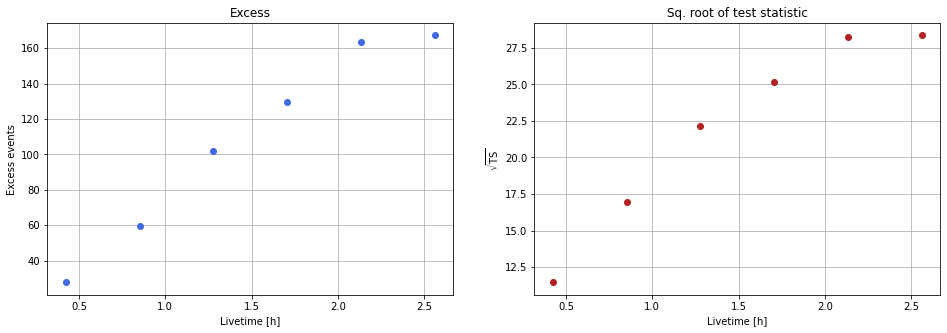

In [24]:
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(1, 2, figsize=(16, 5))

ax_excess.plot(info_table['livetime'].to(u.h), info_table['excess'], 'o', c='royalblue', ls='none')
ax_excess.grid()
ax_excess.set_xlabel('Livetime [h]')
ax_excess.set_ylabel('Excess events')
ax_excess.set_title('Excess')

ax_sqrt_ts.plot(info_table['livetime'].to(u.h), info_table['sqrt_ts'], 'o', c='firebrick', ls='none')
ax_sqrt_ts.grid()
ax_sqrt_ts.set_xlabel('Livetime [h]')
ax_sqrt_ts.set_ylabel(r'$\sqrt{\rm{TS}}$')
ax_sqrt_ts.set_title('Sq. root of test statistic')

plt.show()

In [25]:
spectral_model = LogParabolaSpectralModel.from_log10(amplitude=2.22e-5 / (u.m ** 2 * u.s * u.TeV), 
                                                     reference=0.2 * u.TeV, 
                                                     alpha=2.4, 
                                                     beta=1.8)

In [26]:
print(spectral_model)

LogParabolaSpectralModel

  type      name     value         unit     ... max frozen is_norm link
-------- --------- ---------- ------------- ... --- ------ ------- ----
spectral amplitude 2.2200e-05 m-2 s-1 TeV-1 ... nan  False    True     
spectral reference 2.0000e-01           TeV ... nan   True   False     
spectral     alpha 2.4000e+00               ... nan  False   False     
spectral      beta 7.8173e-01               ... nan  False   False     


In [27]:
### ???

model = SkyModel(spectral_model=spectral_model, name='BL Lacertae')
datasets.models = [model]

fit_joint = Fit()
result_joint = fit_joint.run(datasets=datasets)
model_best_joint = model.copy()

In [28]:
print(spectral_model)

LogParabolaSpectralModel

  type      name     value         unit     ... max frozen is_norm link
-------- --------- ---------- ------------- ... --- ------ ------- ----
spectral amplitude 4.4827e-05 m-2 s-1 TeV-1 ... nan  False    True     
spectral reference 2.0000e-01           TeV ... nan   True   False     
spectral     alpha 3.1007e+00               ... nan  False   False     
spectral      beta 3.6273e-01               ... nan  False   False     


In [29]:
display(result_joint.models.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str11,str8,str9,float64,str13,float64,float64,float64,bool,bool,str1
BL Lacertae,spectral,amplitude,4.4827e-05,m-2 s-1 TeV-1,2.892e-05,nan,nan,False,True,
BL Lacertae,spectral,reference,2.0000e-01,TeV,0.000e+00,nan,nan,True,False,
BL Lacertae,spectral,alpha,3.1007e+00,,9.704e-01,nan,nan,False,False,
BL Lacertae,spectral,beta,3.6273e-01,,3.392e-01,nan,nan,False,False,


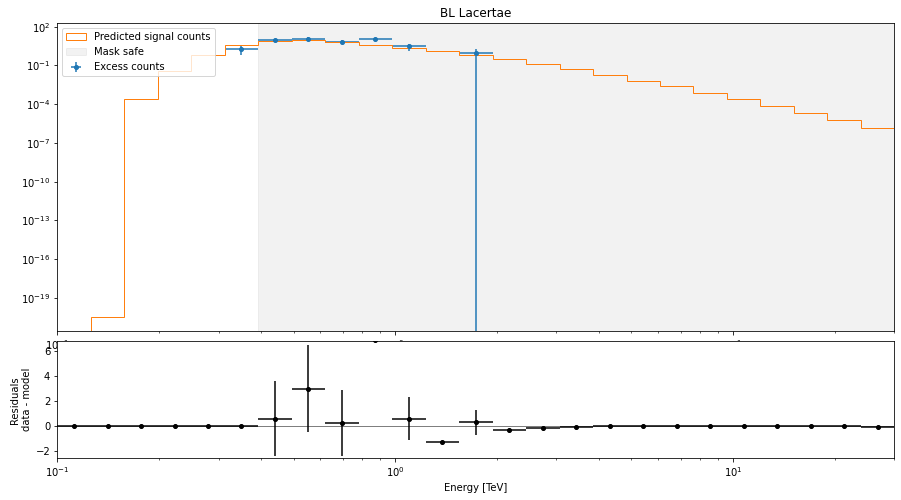

In [30]:
plt.figure(figsize=(15, 8))

ax_spectrum, ax_residuals = datasets[2].plot_fit()

ax_spectrum.set_yscale('log')
datasets[0].plot_masks(ax=ax_spectrum)
ax_spectrum.set_title('BL Lacertae')

plt.show()

In [31]:
# A1 = 2.22e-5
# A2 = 2.36e-5
 
# ref = 0.2

# alpha1 = 2.4
# alpha2 = 2.2

# beta1 = 1.8
# beta2 = 1.4

# def logparab(E, A, ref, alpha, beta):
#     return A * (E / ref) ** (-alpha - beta * np.log10((E / ref)))
    

# energies = np.linspace(0.1, 3, 100000)

# e2fluxes1 = logparab(energies, A1, ref, alpha1, beta1) * energies ** 2
# e2fluxes2 = logparab(energies, A2, ref, alpha2, beta2) * energies ** 2
    
    
# plt.figure(figsize=(15, 8))

# plt.plot(energies * u.TeV.to(u.GeV), 
#          e2fluxes1 * (u.TeV / u.m ** 2 / u.s).to(u.erg / u.cm ** 2 / u.s), 
#          lw=5, c='k', alpha=0.7)

# plt.plot(energies * u.TeV.to(u.GeV), 
#          e2fluxes2 * (u.TeV / u.m ** 2 / u.s).to(u.erg / u.cm ** 2 / u.s), 
#          lw=5, c='royalblue', alpha=0.7)

# plt.xscale('log')
# plt.xlabel(r'$E$ [GeV]', fontsize=15)

# plt.yscale('log')
# plt.ylabel(r'$E^2 dN/dE$ [erg cm$^{-2}$ s$^{-1}$]', fontsize=15)

# plt.grid()
# plt.show()

In [32]:
e_min, e_max = 0.1, 4
energy_edges_1 = np.geomspace(e_min, e_max, 7) * u.TeV
energy_edges = 10 ** np.arange(-0.5, 0.31, 0.2) * u.TeV

In [33]:
energy_edges_1

<Quantity [0.1       , 0.18493112, 0.34199519, 0.63245553, 1.1696071 ,
           2.16296749, 4.        ] TeV>

In [34]:
energy_edges

<Quantity [0.31622777, 0.50118723, 0.79432823, 1.25892541, 1.99526231] TeV>

In [35]:
fpe = FluxPointsEstimator(energy_edges=energy_edges, source='BL Lacertae', selection_optional='all')
flux_points = fpe.run(datasets=datasets)

In [36]:
flux_points.to_table(sed_type='dnde', formatted=True).show_in_notebook()

idx,e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred [6],npred_excess [6],stat,is_ul,counts [6],success,norm_scan [11],stat_scan [11]
,TeV,TeV,TeV,1 / (m2 s TeV),1 / (m2 s TeV),1 / (m2 s TeV),1 / (m2 s TeV),1 / (m2 s TeV),,,,,,,,,,
0,0.393,0.313,0.494,4.517e-06,8.923e-07,9.526e-07,8.359e-07,6.550e-06,130.989,11.445,8.932585793188663 .. 0.0,8.808396 .. 0.0,0.192,False,8.0 .. 0.0,True,0.200 .. 5.000,39.686 .. 130.234
1,0.620,0.494,0.779,8.634e-07,9.315e-08,9.657e-08,8.991e-08,1.064e-06,434.590,20.847,16.184961521285757 .. 6.781219106324946,16.12404 .. 6.781219,17.240,False,13.0 .. 1.0,True,0.200 .. 5.000,157.541 .. 412.096
2,0.979,0.779,1.230,1.261e-07,2.012e-08,2.122e-08,1.909e-08,1.709e-07,173.602,13.176,6.19718803497336 .. 7.632641300353759,6.135629 .. 7.5738177,32.090,False,4.0 .. 0.0,True,0.200 .. 5.000,92.532 .. 231.460
3,1.545,1.230,1.941,1.610e-08,4.944e-09,5.427e-09,4.484e-09,2.796e-08,36.300,6.025,1.7990450114459682 .. 2.3953822441955297,1.733962 .. 2.2043996,11.045,False,3.0 .. 3.0,True,0.200 .. 5.000,25.022 .. 71.065


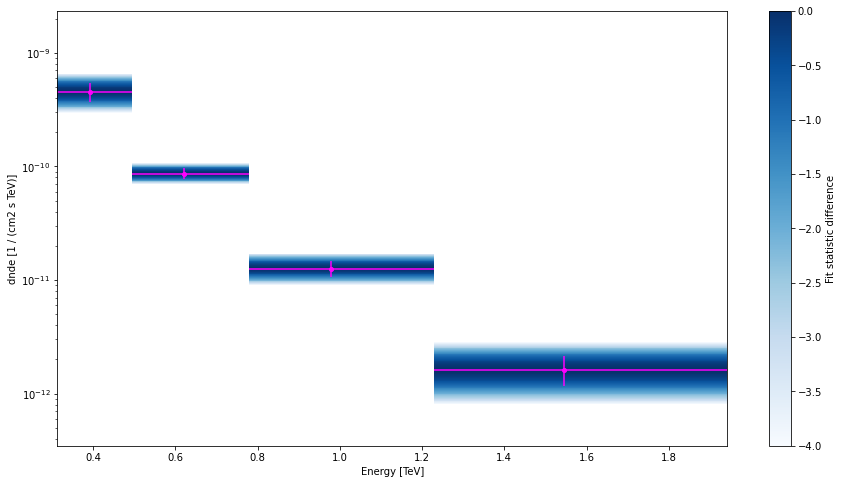

In [37]:
fig, ax = plt.subplots(figsize=(15, 8))
flux_points.plot(ax=ax, sed_type='dnde', c='fuchsia')
flux_points.plot_ts_profiles(ax=ax, sed_type='dnde')
ax.set_xscale('linear')
plt.show()

(<AxesSubplot:xlabel='Energy [TeV]', ylabel='e2dnde [erg / (cm2 s)]'>,
 <AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals\n (data - model) / model'>)

<Figure size 1080x576 with 0 Axes>

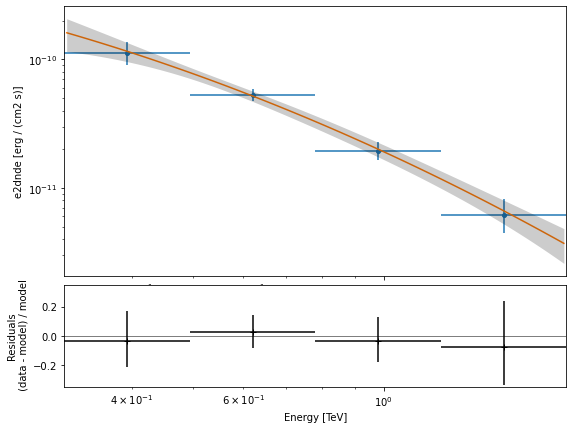

In [38]:
plt.figure(figsize=(15, 8))
flux_points_dataset = FluxPointsDataset(data=flux_points, models=model_best_joint)
flux_points_dataset.plot_fit()

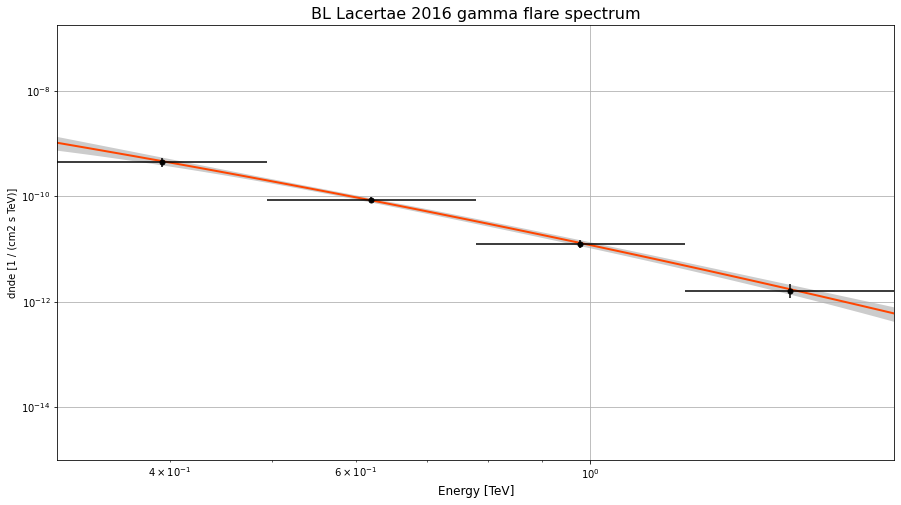

In [39]:
plt.figure(figsize=(15, 8))

energy_bounds = [e_min, e_max] * u.TeV

spectral_model.plot(energy_bounds, label='Log Parabola Fit', color='orangered', lw=2)
spectral_model.plot_error(energy_bounds, alpha=0.2, color='deepskyblue')
flux_points.plot(sed_type='dnde', color='k', markersize=5)

plt.xlabel('Energy [TeV]', fontsize=12)
plt.title('BL Lacertae 2016 gamma flare spectrum', fontsize=16)
plt.grid()

plt.show()

In [40]:
gammapy_flux = flux_points.to_table(sed_type='dnde')
gammapy_flux.show_in_notebook()

idx,e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred [6],npred_excess [6],stat,is_ul,counts [6],success,norm_scan [11],stat_scan [11]
,TeV,TeV,TeV,1 / (m2 s TeV),1 / (m2 s TeV),1 / (m2 s TeV),1 / (m2 s TeV),1 / (m2 s TeV),,,,,,,,,,
0,0.39310548279174495,0.31291346445318985,0.49384874144349267,4.5174850561087975e-06,8.923322078949301e-07,9.526063099695825e-07,8.359216655278775e-07,6.5497823624754715e-06,130.98896676602186,11.44504114304627,8.932585793188663 .. 0.0,8.808396 .. 0.0,0.1921669172072562,False,8.0 .. 0.0,True,0.2 .. 4.999999999999999,39.68602589887588 .. 130.234473215812
1,0.6204100174164326,0.49384874144349267,0.779405833020029,8.634463700766399e-07,9.31475217475468e-08,9.656704965717296e-08,8.9909940285132e-08,1.0639806223926884e-06,434.5899716339501,20.84682161946876,16.184961521285757 .. 6.781219106324946,16.12404 .. 6.781219,17.239659875014524,False,13.0 .. 1.0,True,0.2 .. 4.999999999999999,157.5411990491541 .. 412.09566645736714
2,0.9791483623609769,0.779405833020029,1.230079985159087,1.2612570199765e-07,2.0119539702602328e-08,2.1215141696103717e-08,1.9093751298568588e-08,1.7088965904279742e-07,173.6015212197337,13.175793001551508,6.19718803497336 .. 7.632641300353759,6.135629 .. 7.5738177,32.09048137262292,False,4.0 .. 0.0,True,0.2 .. 4.999999999999999,92.53152794292569 .. 231.4599509170401
3,1.5453192060093084,1.230079985159087,1.9413464793123973,1.6097563114462453e-08,4.943668024366862e-09,5.426731590838168e-09,4.484496653643236e-09,2.795910096091675e-08,36.300251004935646,6.024968962985257,1.7990450114459682 .. 2.3953822441955297,1.733962 .. 2.2043996,11.044500327106965,False,3.0 .. 3.0,True,0.2 .. 4.999999999999999,25.021843733942895 .. 71.06542773457964


In [41]:
chi_sq, dof = reduced_chi_sq(gammapy_flux['dnde'], spectral_model(gammapy_flux['e_ref']), gammapy_flux['dnde_err'], 4)
print(chi_sq, dof)

0.1941862295959071 0


In [42]:
hdul = fits.open('BL_Lacertae/bl_combine.fits')
ste_spectrum = Table.read(hdul[1])
ste_model = Table.read(hdul[2])

In [43]:
ste_spectrum

E,dNdE,dNdE_errl,dNdE_erru,dNdE_ul,Hz,nuFnu,nuFnu_errl,nuFnu_erru,nuFnu_ul,Sigma
TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),Hz,erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.39810717055349704,2.594568396658546e-10,1.7531998788451783e-11,1.8328744267171375e-11,0.0,9.626188555952215e+25,6.588332629467718e-11,4.451863355250235e-12,4.654179248775704e-12,0.0,0.0
0.6309573444801928,6.225869491350621e-11,5.176365952855205e-12,5.47399791560092e-12,0.0,1.5256480711675739e+26,3.9710961850216795e-11,3.3016829402249626e-12,3.4915239180099986e-12,0.0,0.0
0.9999999999999992,1.2755113059947644e-11,1.6137508116126233e-12,1.7578911604462704e-12,0.0,2.417989242084916e+26,2.043594410867632e-11,2.5855138434642765e-12,2.8164521423821543e-12,0.0,0.0
1.584893192461112,1.7159468830440653e-12,4.112787859663585e-13,4.882137739821135e-13,0.0,3.83225468922459e+26,6.905803774837774e-12,1.655185612504906e-12,1.9648093752834976e-12,0.0,0.0
2.5118864315095766,0.0,0.0,0.0,5.61924080180172e-13,6.0737143687292305e+26,0.0,0.0,0.0,5.680519265456438e-12,0.0


In [44]:
paper = Table.read('BL_Lacertae/VER-000148-sed-1.ecsv', format='ascii.ecsv')
paper

e_ref,e_min,e_max,e2dnde,e2dnde_err
TeV,TeV,TeV,erg / (cm2 s),erg / (cm2 s)
float32,float32,float32,float32,float32
0.1567,0.1259,0.1995,1.491028e-10,6.01919e-12
0.2484,0.1995,0.3162,1.285154e-10,4.666097e-12
0.3937,0.3162,0.5012,6.878903e-11,3.625703e-12
0.6239,0.5012,0.7943,3.467475e-11,2.875011e-12
0.9888,0.7943,1.2589,8.41201e-12,1.78579e-12
1.567,1.2589,1.9953,2.915176e-12,1.510699e-12


In [45]:
exponents = np.log10(paper['e_min']) + np.log10(paper['e_max'])
E_mean_sq = 10 ** exponents * (u.TeV.to(u.erg)) ** 2 

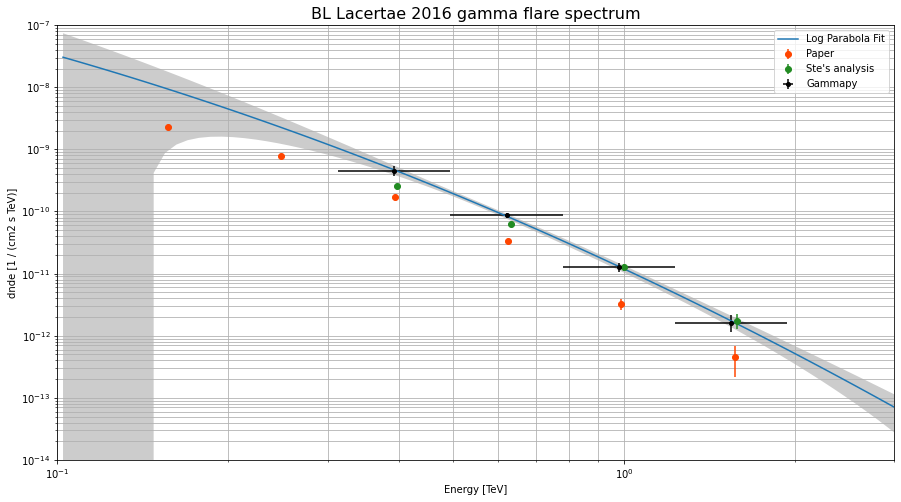

In [46]:
fig, ax = plt.subplots(figsize=(15, 8))

plt.errorbar(paper['e_ref'], paper['e2dnde'] / E_mean_sq, yerr=paper['e2dnde_err'] / E_mean_sq, 
             color='orangered', ls='', marker='o', label='Paper')

plt.errorbar(ste_spectrum['E'], ste_spectrum['dNdE'], yerr=(ste_spectrum['dNdE_errl'], ste_spectrum['dNdE_erru']),
             color='forestgreen', ls='', marker='o', label='Ste\'s analysis')

flux_points.plot(ax=ax, sed_type="dnde", color="k", label='Gammapy')

energy_bounds = [0.1, 10] * u.TeV

spectral_model.plot(energy_bounds, sed_type='dnde', label='Log Parabola Fit')
spectral_model.plot_error(energy_bounds, sed_type='dnde', alpha=0.2)

ax.set_xscale('log')
ax.grid(which='minor')
ax.grid(which='major')
ax.legend()

ax.set_xlim(0.1, 3)
ax.set_ylim(1e-14,1e-7)

plt.title('BL Lacertae 2016 gamma flare spectrum', fontsize=16)

plt.show()

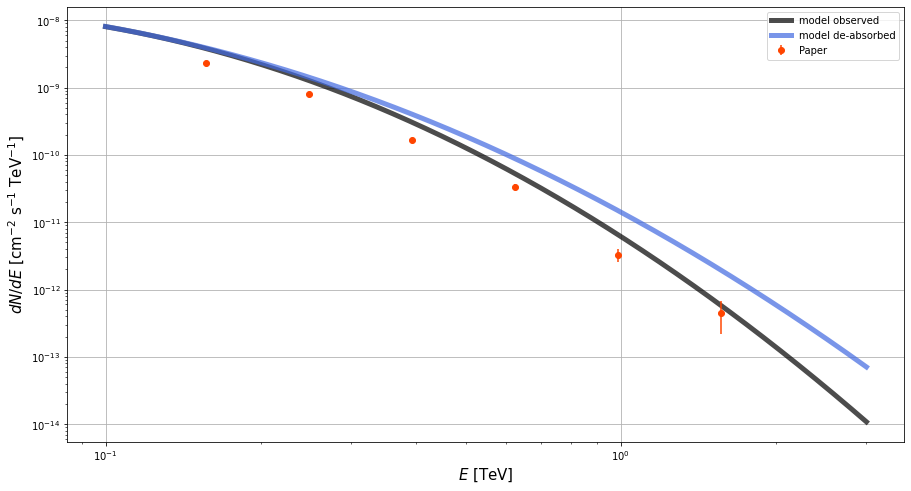

In [47]:
A1 = 2.22e-5
A2 = 2.36e-5
 
ref = 0.2

alpha1 = 2.4
alpha2 = 2.2

beta1 = 1.8
beta2 = 1.4

def logparab(E, A, ref, alpha, beta):
    return A * (E / ref) ** (-alpha - beta * np.log10((E / ref)))
    

energies = np.linspace(0.1, 3, 100000)

e2fluxes1 = logparab(energies, A1, ref, alpha1, beta1) * energies ** 2
e2fluxes2 = logparab(energies, A2, ref, alpha2, beta2) * energies ** 2
    
    
plt.figure(figsize=(15, 8))

plt.plot(energies, 
         logparab(energies, A1, ref, alpha1, beta1) * (u.m ** -2).to(u.cm ** -2), 
         lw=5, c='k', alpha=0.7, label='model observed')

plt.plot(energies, 
         logparab(energies, A2, ref, alpha2, beta2) * (u.m ** -2).to(u.cm ** -2), 
         lw=5, c='royalblue', alpha=0.7, label='model de-absorbed')

plt.errorbar(paper['e_ref'], paper['e2dnde'] / E_mean_sq, yerr=paper['e2dnde_err'] / E_mean_sq, 
             color='orangered', ls='', marker='o', label='Paper')

plt.legend()

plt.xscale('log')
plt.xlabel(r'$E$ [TeV]', fontsize=15)

plt.yscale('log')
plt.ylabel(r'$dN/dE$ [cm$^{-2}$ s$^{-1}$ TeV$^{-1}$]', fontsize=15)

plt.grid()
plt.show()

In [99]:
start_mjd = Time(57666.165, format='mjd')
print(start_mjd.iso)

2016-10-05 03:57:36.000


In [173]:
t0 = Time('2016-10-05T03:57:36.000')

duration = 4 * u.min
n_time_bins = 46
times = t0 + np.arange(n_time_bins) * duration
time_intervals = [Time([tstart, tstop]) for tstart, tstop in zip(times[:-1], times[1:])]

In [174]:
short_observations = observations.select_time(time_intervals)

print(f"Number of observations after time filtering: {len(short_observations)}\n")
print(short_observations[1].gti)

Number of observations after time filtering: 50

GTI info:
- Number of GTIs: 1
- Duration: 240.0 s
- Start: 368424100.0 s MET
- Start: 2016-10-05T04:01:36.000 (time standard: UTC)
- Stop: 368424340.0 s MET
- Stop: 2016-10-05T04:05:36.000 (time standard: UTC)



In [175]:
#redo?

dataset_maker = SpectrumDatasetMaker(containment_correction=False, selection=["counts", "exposure", "edisp"])
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

datasets = Datasets()

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

for obs in short_observations:
    dataset = dataset_maker.run(dataset_empty.copy(), obs)
    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

In [176]:
spectral_model = PowerLawSpectralModel(index=2.6, amplitude=4.64e-12 / u.cm ** 2 / u.s / u.TeV)
spectral_model.parameters.frozen = False

sky_model = SkyModel(spatial_model=None, spectral_model=spectral_model, name="BL Lacertae")

In [177]:
datasets.models = sky_model

In [178]:
lc_maker_1d = LightCurveEstimator(energy_edges=[0.1, 10] * u.TeV, source=0, 
                                  time_intervals=time_intervals, selection_optional=None)

In [179]:
lc_1d = lc_maker_1d.run(datasets)

In [180]:
header="""# %ECSV 1.0
# ---
# datatype:
# - {name: time_min, datatype: float64}
# - {name: time_max, datatype: float64}
# - {name: e_ref, unit: TeV, datatype: string, subtype: 'float64[1]'}
# - {name: e_min, unit: TeV, datatype: string, subtype: 'float64[1]'}
# - {name: e_max, unit: TeV, datatype: string, subtype: 'float64[1]'}
# - {name: flux, unit: 1 / (m2 s), datatype: string, subtype: 'float64[1]'}
# - {name: flux_err, unit: 1 / (m2 s), datatype: string, subtype: 'float64[1]'}
# - {name: ts, unit: '', datatype: string, subtype: 'float64[1]'}
# - {name: sqrt_ts, unit: '', datatype: string, subtype: 'float64[1]'}
# - {name: npred, unit: '', datatype: string, subtype: 'float64[1,44]'}
# - {name: npred_excess, unit: '', datatype: string, subtype: 'float64[1,44]'}
# - {name: stat, unit: '', datatype: string, subtype: 'float64[1]'}
# - {name: is_ul, datatype: string, subtype: 'bool[1]'}
# - {name: counts, unit: '', datatype: string, subtype: 'float64[1,44]'}
# - {name: success, unit: '', datatype: string, subtype: 'bool[1]'}
# schema: astropy-2.0
time_min time_max e_ref e_min e_max flux flux_err ts sqrt_ts npred npred_excess stat is_ul counts success"""

with open("temptest.ecsv", "w") as myfile:
    myfile.write(header)

In [181]:
imp_tab = Table.read('BL_Lacertae/VER-000148-lc-1.ecsv', format='ascii.ecsv')

In [182]:
imp_tab

e_min,time,flux,flux_err,live_time
TeV,MJD,1 / (m2 s),1 / (m2 s),s
float64,float64,float64,float64,float64
0.2,57666.16512883,2.066401349209e-06,3.977646067535e-07,205.5610568
0.2,57666.16790661,6.277083521201e-07,2.506630695002e-07,203.7551391
0.2,57666.17068439,1.661787379172e-06,3.761323190921e-07,202.3007885
0.2,57666.17346217,1.908301901719e-06,3.916051209587e-07,202.6086559
0.2,57666.17623994,1.441257359224e-06,3.429916705453e-07,202.1973822
0.2,57666.17901772,1.22214372509e-06,3.287038174212e-07,202.6614211
...,...,...,...,...
0.2,57666.27623994,1.404628507373e-06,3.549020972938e-07,203.6483376


In [183]:
# imp_tab["e_max"] = imp_tab["e_cut"]
# imp_tab["e_ref"] = np.exp(np.log(imp_tab["e_min"]) + np.log(imp_tab["e_max"]) / 2)

# imp_tab["time_min"] = imp_tab["e_cut"]
# imp_tab["time_max"] = imp_tab["time"] + (imp_tab["time_bin"] / 2.01)
# imp_tab["time_min"] = imp_tab["time"] - (imp_tab["time_bin"] / 2.01)

# extend = '[[NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,' \
# + 'NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN]] ' \
# + '[[NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,' \
# + 'NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN]] [0.0] [false] ' \
# + '[[NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,' \
# + 'NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN]] [true]'

# for i in range(len(imp_tab)):

#     with open("temptest.ecsv", "a") as myfile:
#         myfile.write(f'\n{imp_tab[i]["time_min"]} {imp_tab[i]["time_max"]} [{imp_tab[i]["e_ref"]}] ' \
#                      + f'[{imp_tab[i]["e_min"]}] [{imp_tab[i]["e_max"]}] [{imp_tab[i]["flux"]}] ' \
#                      + f'[{imp_tab[i]["flux_err"]}] [0] [0] {extend}')

# lc_test=FluxPoints.read('temptest.ecsv', reference_model=spectral_model, sed_type='flux', format='lightcurve')

In [184]:
haha = Time(imp_tab['time'][0], format='mjd')
hoho = Time(imp_tab['time'][-1], format='mjd')

In [185]:
print(hoho-haha)

0.125


In [186]:
0.125 * u.day.to(u.min)

180.0

In [187]:
print(haha.to_datetime())

2016-10-05 03:57:47.130912


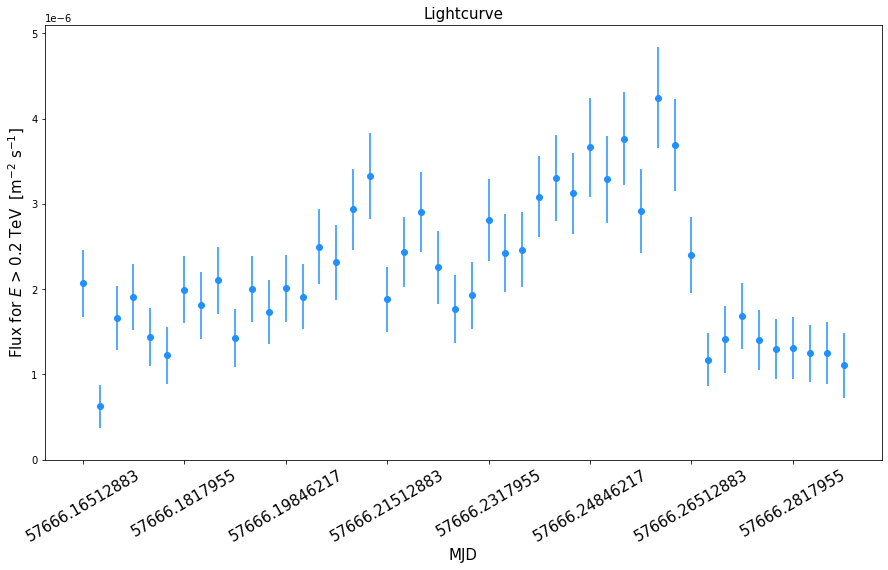

In [188]:
plt.figure(figsize=(15, 8))

plt.errorbar(imp_tab['time'], imp_tab['flux'], yerr=imp_tab['flux_err'], marker='o', ls='', color='dodgerblue')

plt.xlabel('MJD', fontsize=15)
plt.xticks(ticks=imp_tab['time'][::6], labels=imp_tab['time'][::6], rotation=30, fontsize=15)

plt.ylabel(r'Flux for $E$ > 0.2 TeV  [m$^{-2}$ s$^{-1}$]', fontsize=15)
plt.ylim(0, 5.1e-6)

plt.title('Lightcurve', fontsize=15)

plt.show()

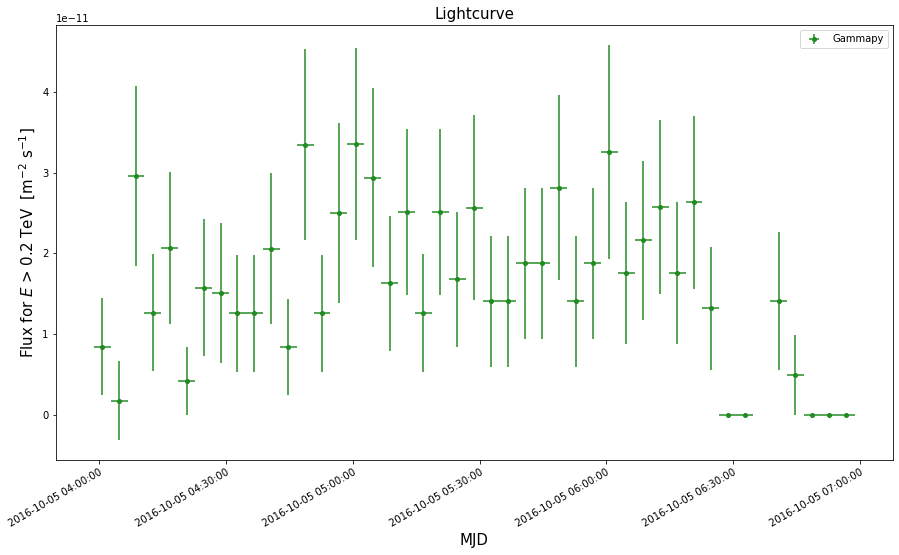

In [194]:
plt.figure(figsize=(15, 8))

lc_1d.plot(marker='o', color='forestgreen', label='Gammapy')
# plt.errorbar(imp_tab['time'], imp_tab['flux'], yerr=imp_tab['flux_err'], marker='o', ls='', color='dodgerblue',
#              label='Paper')

plt.xlabel('MJD', fontsize=15)
#plt.xticks(ticks=imp_tab['time'][::6], labels=imp_tab['time'][::6], rotation=30, fontsize=15)

plt.ylabel(r'Flux for $E$ > 0.2 TeV  [m$^{-2}$ s$^{-1}$]', fontsize=15)
#plt.ylim(0, 5.1e-6)

plt.yscale('linear')

plt.title('Lightcurve', fontsize=15)

plt.show()

In [190]:
xwings = []
emjaydees = []

for i in range(len(times) - 1):
    
    a = times.mjd[i + 1]
    b = times.mjd[i]
    
    wing = abs(a - b) / 2 
    mid = (a + b) / 2
    
    xwings.append(wing)
    emjaydees.append(mid)
    
xwings = np.array(xwings)
emjaydees = np.array(emjaydees)

In [191]:
simplicity = abs(imp_tab['time'][1] - imp_tab['time'][0]) / 2    

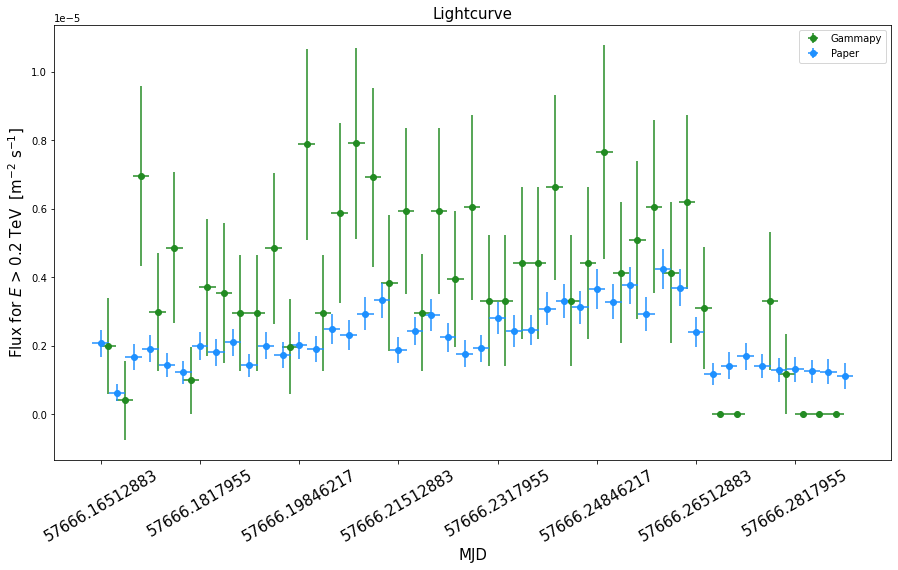

In [192]:
plt.figure(figsize=(15, 8))

plt.errorbar(emjaydees, lc_1d.flux.data[:,0,0,0] * (u.cm ** -2).to(u.m ** -2), 
             xerr=xwings, yerr=lc_1d.flux_err.data[:,0,0,0] * (u.cm ** -2).to(u.m ** -2),
             marker='o', ls='', color='forestgreen', label='Gammapy')
plt.errorbar(imp_tab['time'], imp_tab['flux'], 
             xerr=simplicity, yerr=imp_tab['flux_err'],
             marker='o', ls='', color='dodgerblue', label='Paper')

plt.xlabel('MJD', fontsize=15)
plt.xticks(ticks=imp_tab['time'][::6], labels=imp_tab['time'][::6], rotation=30, fontsize=15)

plt.ylabel(r'Flux for $E$ > 0.2 TeV  [m$^{-2}$ s$^{-1}$]', fontsize=15)
#plt.ylim(0, 5.1e-6)

plt.legend()

plt.title('Lightcurve', fontsize=15)

plt.show()